## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
!pip install plotly textblob wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 70.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 115.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 kB 98.5 MB/s eta 0:00:00


In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from spacy import load
nlp = load("en_core_web_sm")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.shape

(78313, 22)

In [8]:
#print the column names
df_columns = df.columns
print(df_columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [9]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [10]:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [12]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [13]:
df.shape

(21072, 22)

In [14]:
blank_value = df['complaint_what_happened'].isna().any() or (df['complaint_what_happened'] == '').any()
print("Blank or missing values exist in 'complaint_what_happened':", blank_value)

Blank or missing values exist in 'complaint_what_happened': False


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def textclean(data):
    data = data.lower()
    data = re.sub('\[.*?\]', '', data) 
    data = re.sub('[^\w\s]', '', data)
    data = re.sub('\w*\d\w*', '', data)
    return data

In [16]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: textclean(x))

In [17]:
df['complaint_what_happened'].head(2)

1    good morning my name is xxxx xxxx and i apprec...
2    i upgraded my xxxx xxxx card in  and was told ...
Name: complaint_what_happened, dtype: object

In [18]:
#Write your function to Lemmatize the texts
def textlemma(data):
    doc = nlp(data)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [19]:
df['complaint_lemm'] = df['complaint_what_happened'].apply(lambda x: textlemma(x))

In [20]:
df['complaint_lemm'].head(2)

1    good morning my name be xxxx xxxx and I apprec...
2    I upgrade my xxxx xxxx card in   and be tell b...
Name: complaint_lemm, dtype: object

In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened','complaint_lemm']]

In [22]:
df_clean.head()

,complaint_what_happened,complaint_lemm
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [23]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

In [24]:
df_clean['complaint_POS_removed'] = df_clean['complaint_lemm'].apply(lambda x: pos_tag(x))

/tmp/ipykernel_59/3786717071.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean_pos = df_clean
df_clean_pos

,complaint_what_happened,complaint_lemm,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<Figure size 1000x600 with 0 Axes>

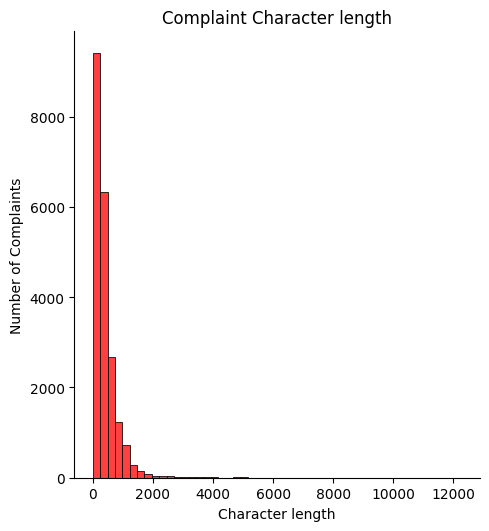

In [26]:
# Write your code here to visualise the data according to the 'Complaint' character length
length = [len(char) for char in df_clean_pos['complaint_POS_removed']]

# Plot the distribution of document lengths using displot
plt.figure(figsize=(10, 6))
sns.displot(length, kind='hist', bins=50, color='red')

plt.xlabel("Character length")
plt.ylabel("Number of Complaints")
plt.title("Complaint Character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

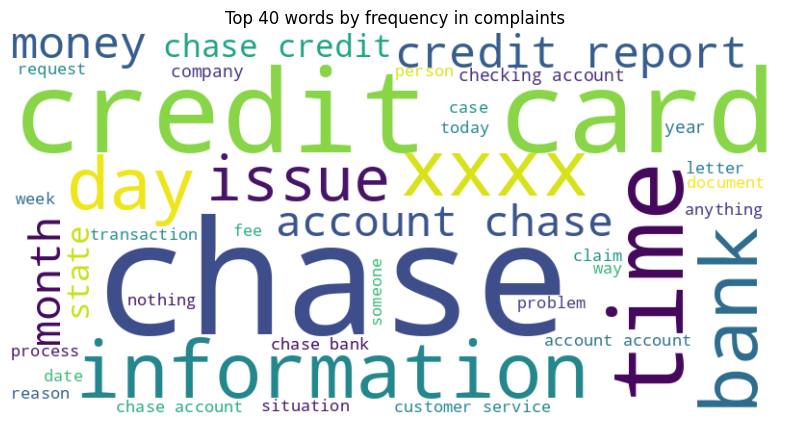

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate(' '.join(df_clean_pos['complaint_POS_removed']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 words by frequency in complaints')
plt.show()

In [28]:
#Removing -PRON- from the text corpus
df_clean_pos['Complaint_clean'] = df_clean_pos['complaint_POS_removed'].str.replace('-PRON-', '')

/tmp/ipykernel_59/3236182589.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def top_n_grams_sklearn(df, column_name, n=1, top_n=30):
    # Create a CountVectorizer object with the desired n-gram range
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=top_n)

    # Fit the vectorizer to the data and transform it into a document-term matrix
    dt_matrix = vectorizer.fit_transform(df[column_name])

    # Calculate the n-gram frequencies by summing the document-term matrix
    n_gram_freq = dt_matrix.sum(axis=0)
    n_gram_freq = n_gram_freq.tolist()[0]

    # Get the feature names (n-grams) and their corresponding frequencies
    n_grams = vectorizer.get_feature_names_out()
    n_gram_freq_pairs = list(zip(n_grams, n_gram_freq))

    # Sort the n-grams by their frequency and return the top n
    sorted_n_gram_freq_pairs = sorted(n_gram_freq_pairs, key=lambda x: x[1], reverse=True)[:top_n]

    return sorted_n_gram_freq_pairs

In [30]:
#Print the top 10 words in the unigram frequency
top_30_unigrams = top_n_grams_sklearn(df_clean_pos, 'Complaint_clean', n=1, top_n=30)
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['unigram', 'count'])
top_30_unigrams_df

,unigram,count
0,chase,61664
1,account,46360
2,credit,33101
3,card,29872
4,payment,21059
5,bank,17871
6,time,16004
7,charge,14327
8,day,12873
9,money,11950


In [31]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = top_n_grams_sklearn(df_clean_pos, 'Complaint_clean', n=2, top_n=30)
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['unigram', 'count'])

In [32]:
#Print the top 10 words in the bigram frequency
top_30_bigrams_df

,unigram,count
0,credit card,12605
1,credit report,3914
2,chase credit,3438
3,account chase,3377
4,checking account,3338
5,customer service,2956
6,chase bank,2769
7,chase account,2723
8,account account,2290
9,bank account,2156


In [33]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = top_n_grams_sklearn(df_clean_pos, 'Complaint_clean', n=3, top_n=30)
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['unigram', 'count'])

In [34]:
#Print the top 10 words in the trigram frequency
top_30_trigrams_df

,unigram,count
0,chase credit card,2395
1,credit card account,1030
2,credit card company,981
3,credit card chase,779
4,chase customer service,583
5,inquiry credit report,512
6,credit card credit,497
7,chase checking account,469
8,account credit card,410
9,charge credit card,382


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [35]:
df_clean_pos['Complaint_clean'] = df_clean_pos['Complaint_clean'].str.replace('xxxx','')

/tmp/ipykernel_59/3421822029.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
#All masked texts has been removed
df_clean_pos

,complaint_what_happened,complaint_lemm,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [37]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
df_mat= tfidf.fit_transform(df_clean_pos['Complaint_clean'])

In [39]:
df_mat

<21072x6635 sparse matrix of type '<class 'numpy.float64'>'
	with 601121 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [40]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [42]:
W =nmf_model.fit_transform(df_mat)
H = nmf_model.components_
len(tfidf.get_feature_names())

/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6635

In [43]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,checking,branch,day,transaction,number,business,claim,transfer
Topic 2,card,charge,chase,dispute,fee,credit,transaction,purchase,merchant,fraud,service,claim,time,balance,customer
Topic 3,loan,mortgage,chase,home,modification,property,year,letter,document,time,rate,foreclosure,house,sale,request
Topic 4,credit,report,inquiry,card,account,score,company,chase,debt,information,application,limit,reporting,identity,letter
Topic 5,payment,balance,month,fee,statement,day,time,chase,auto,date,credit,pay,year,mortgage,account


In [44]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_set = nmf_model.transform(df_mat)

In [45]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean_pos['Topic'] = topic_set.argmax(axis=1)#write your code to assign topics to each rows.

/tmp/ipykernel_59/98955681.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
df_clean_pos.head(5)

,complaint_what_happened,complaint_lemm,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [47]:
#Print the first 5 Complaint for each of the Topics
df_clean_pos_top5=df_clean_pos.groupby('Topic').head(5)
df_clean_pos_top5.sort_values('Topic')

,complaint_what_happened,complaint_lemm,complaint_POS_removed,Complaint_clean,Topic
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account code bonus term everything account dep...,account code bonus term everything account dep...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice chase account debit card branch custome...,notice chase account debit card branch custome...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
45,i made a purchase with xxxx xxxx xxxx on in t...,I make a purchase with xxxx xxxx xxxx on in ...,purchase amount charge transaction dispute cas...,purchase amount charge transaction dispute cas...,1
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card charge b...,sofa love seat table chair debit card charge b...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,chase amazon card decline catering order place...,1
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charge wrong...,concern charge overdraft fee alert balance fee...,concern charge overdraft fee alert balance fee...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [48]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans"  }
#Replace Topics with Topic Names
df_clean_pos['Topic'] = df_clean_pos['Topic'].map(Topic_names)

/tmp/ipykernel_59/3120017465.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
df_clean_pos

,complaint_what_happened,complaint_lemm,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Others
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,Bank account services
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute reporting
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Theft/Dispute reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Credit card / Prepaid card
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...,Credit card / Prepaid card
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Mortgages/loans


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [50]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4   }
#Replace Topics with Topic Names
df_clean_pos['Topic'] = df_clean_pos['Topic'].map(Topic_names)

/tmp/ipykernel_59/2012232619.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_clean_pos

,complaint_what_happened,complaint_lemm,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,2
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,1
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank app chase year bankin...,risk consumer chase bank app chase year bankin...,1
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,4


In [52]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean_pos[['complaint_what_happened', 'Topic']]

In [53]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,2
2,i upgraded my xxxx xxxx card in and was told ...,0
10,chase card was reported on however fraudulent...,3
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,1
78310,i am not familiar with xxxx pay and did not un...,1
78311,i have had flawless credit for yrs ive had ch...,4


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [54]:
X = training_data['complaint_what_happened']
y = training_data['Topic']

In [55]:

#Write your code to get the Vector count
vector_count = CountVectorizer()
X_vector = vector_count.fit_transform(X)


In [56]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_vector)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Logistic Regression

In [57]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)

In [58]:
def display_classification(model, metric):
    def compute_metrics(y_true, y_pred, y_pred_proba):
        roc_auc = round(roc_auc_score(y_true, y_pred_proba, average='weighted', multi_class='ovr'), 2)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        accuracy = round(accuracy_score(y_true, y_pred), 2)
        return roc_auc, accuracy, round(precision, 2), round(recall, 2), round(fscore, 2)

    for prefix, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
        y_pred = model.predict(X)
        y_pred_proba = model.predict_proba(X)
        roc_auc, accuracy, precision, recall, fscore = compute_metrics(y, y_pred, y_pred_proba)
        
        print(f"{prefix} ROC AUC Score: {roc_auc}")
        print(f"{prefix} Accuracy: {accuracy}")
        print(f"Classification Report for {prefix}:\n{classification_report(y, y_pred)}")
        
        metric.extend([roc_auc, accuracy, precision, recall, fscore])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)
    plt.show()

In [59]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [60]:
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [61]:
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

Train ROC AUC Score: 1.0
Train Accuracy: 0.96
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4063
           1       0.95      0.97      0.96      4411
           2       0.96      0.96      0.96      2901
           3       0.96      0.94      0.95      2638
           4       0.98      0.89      0.93      1791

    accuracy                           0.96     15804
   macro avg       0.96      0.95      0.95     15804
weighted avg       0.96      0.96      0.96     15804

Test ROC AUC Score: 0.99
Test Accuracy: 0.91
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1389
           1       0.90      0.93      0.92      1457
           2       0.92      0.93      0.92       923
           3       0.93      0.89      0.91       908
           4       0.95      0.83      0.89       591

    accuracy                 

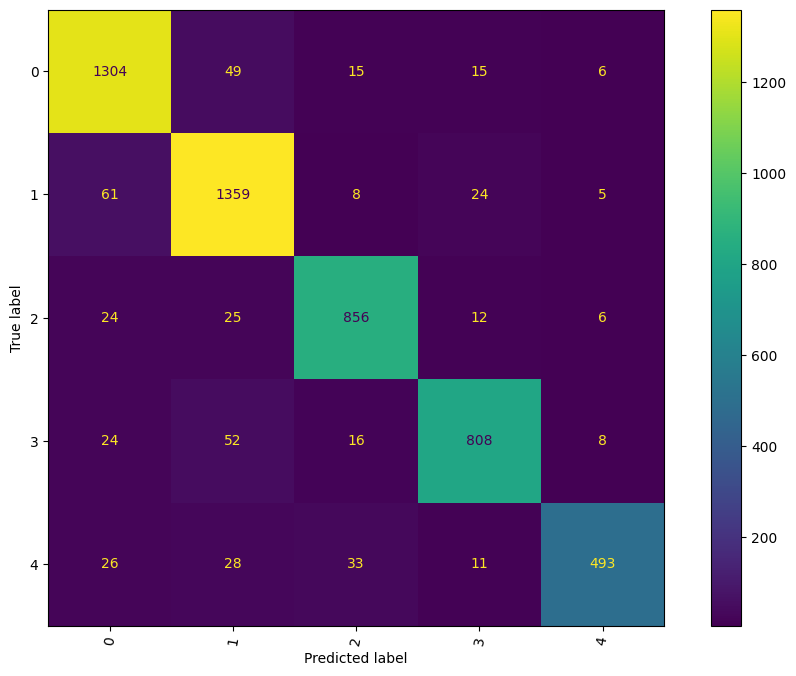

In [62]:
log_model = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_model.fit(X_train,y_train)
# display classification report
report1=[]
display_classification(log_model,report1)

With the simple Logistic regression Model we get accuracy of around 91%.

#### Logistic Regression With HyperParameter Tuning

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

Best Score:  0.9414072217172101
Best Hyperparameters:  {'C': 2, 'penalty': 'l1', 'solver': 'saga'}
Train ROC AUC Score: 1.0
Train Accuracy: 0.97
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4063
           1       0.96      0.97      0.96      4411
           2       0.97      0.97      0.97      2901
           3       0.96      0.96      0.96      2638
           4       0.97      0.96      0.97      1791

    accuracy                           0.97     15804
   macro avg       0.97      0.96      0.97     15804
weighted avg       0.97      0.97      0.97     15804

Test ROC AUC Score: 1.0
Test Accuracy: 0.94
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1389
           1       0.94      0.93      0.93      1457
           2       0.95      0.95      0.95       923
           3       0.93      0.92      0

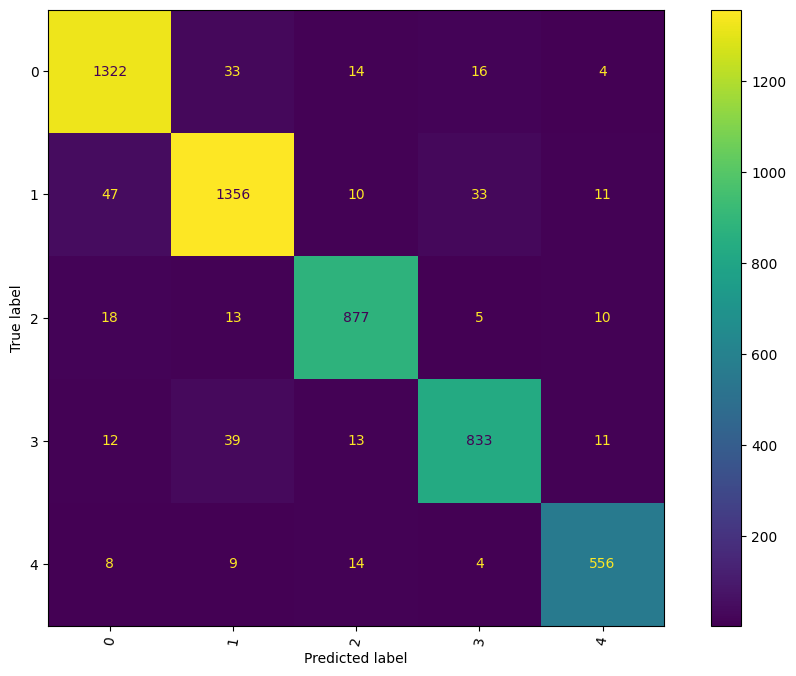

In [63]:
log_model2 = LogisticRegression()

log_hyp = {'C': [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                'solver': ['liblinear','newton-cg','saga'],'penalty': ['l1', 'l2']}


grid_search_model2 = grid_search(log_model2, folds, log_hyp, scoring=None)

grid_search_model2.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_model2)

# Random Forest Classification Report
report2=[]
display_classification(grid_search_model2,report2)

With the hypertuning Logistic regression Model we get accuracy of around 94%. on the Best Hyperparameters:  {'C': 2, 'penalty': 'l1', 'solver': 'saga'}

#### Decision Tree Classifier

Train ROC AUC Score: 1.0
Train Accuracy: 1.0
Classification Report for Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4063
           1       1.00      1.00      1.00      4411
           2       1.00      1.00      1.00      2901
           3       1.00      1.00      1.00      2638
           4       1.00      1.00      1.00      1791

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Test ROC AUC Score: 0.86
Test Accuracy: 0.78
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1389
           1       0.78      0.78      0.78      1457
           2       0.81      0.82      0.81       923
           3       0.75      0.74      0.75       908
           4       0.73      0.76      0.75       591

    accuracy                  

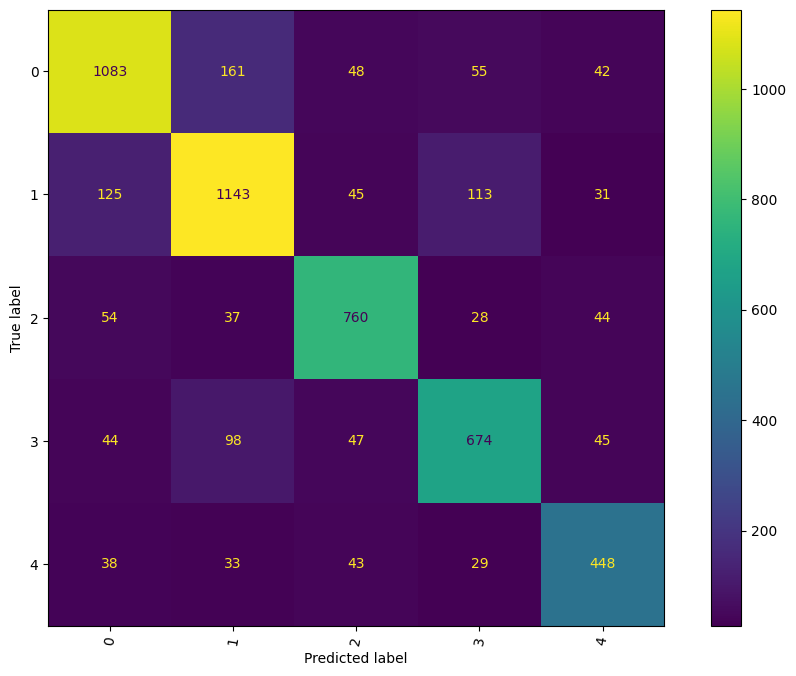

In [64]:
log_model3 = DecisionTreeClassifier(random_state=40)
# fit model
log_model3.fit(X_train,y_train)
# display classification report
report3=[]
display_classification(log_model3,report3)

With the simple Decision Tree Classifier Model we get accuracy of around 78%.

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Score:  0.7732217212146453
Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}
Train ROC AUC Score: 0.96
Train Accuracy: 0.83
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4063
           1       0.86      0.79      0.82      4411
           2       0.73      0.91      0.81      2901
           3       0.88      0.77      0.82      2638
           4       0.90      0.83      0.86      1791

    accuracy                           0.83     15804
   macro avg       0.84      0.83      0.83     15804
weighted avg       0.84      0.83      0.83     15804

Test ROC AUC Score: 0.91
Test Accuracy: 0.78
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1389
           1       0.79      0.74      0.77      1457
       

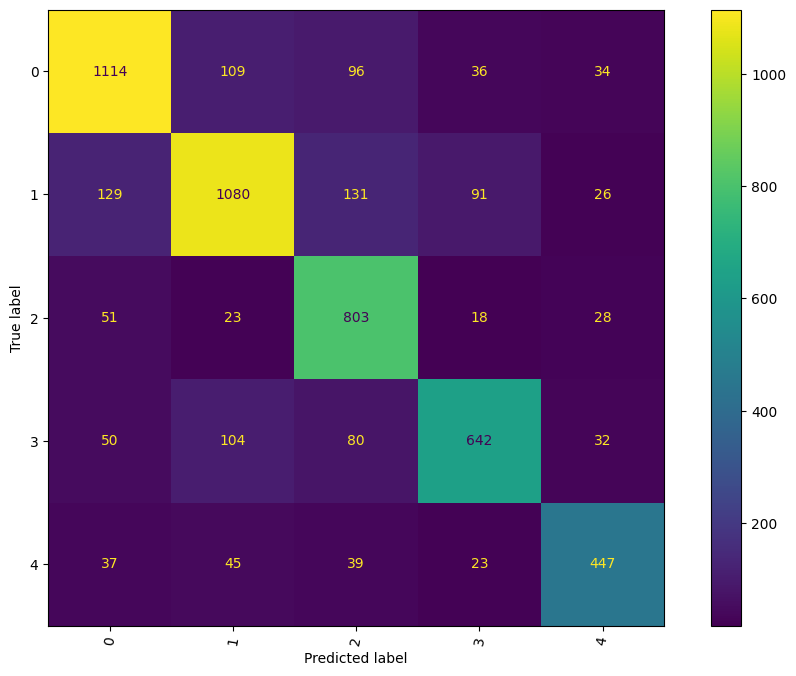

In [65]:
log_model4 = DecisionTreeClassifier(random_state=40)

log_hyp4 = {'max_depth': [3, 4, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2)}


grid_search_model4 = grid_search(log_model4, folds, log_hyp4, scoring=None)

grid_search_model4.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_model4)

# Random Forest Classification Report
report4=[]
display_classification(grid_search_model4,report4)

With the hypertuned  Decision Tree Classifier Model we get accuracy of around 78%. It did not change much with the selected best parameters of Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}

#### Random Forest Classifier

Train ROC AUC Score: 1.0
Train Accuracy: 1.0
Classification Report for Train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4063
           1       1.00      1.00      1.00      4411
           2       1.00      1.00      1.00      2901
           3       1.00      1.00      1.00      2638
           4       1.00      1.00      1.00      1791

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Test ROC AUC Score: 0.97
Test Accuracy: 0.81
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1389
           1       0.76      0.88      0.82      1457
           2       0.85      0.86      0.86       923
           3       0.87      0.77      0.82       908
           4       0.92      0.38      0.54       591

    accuracy                  

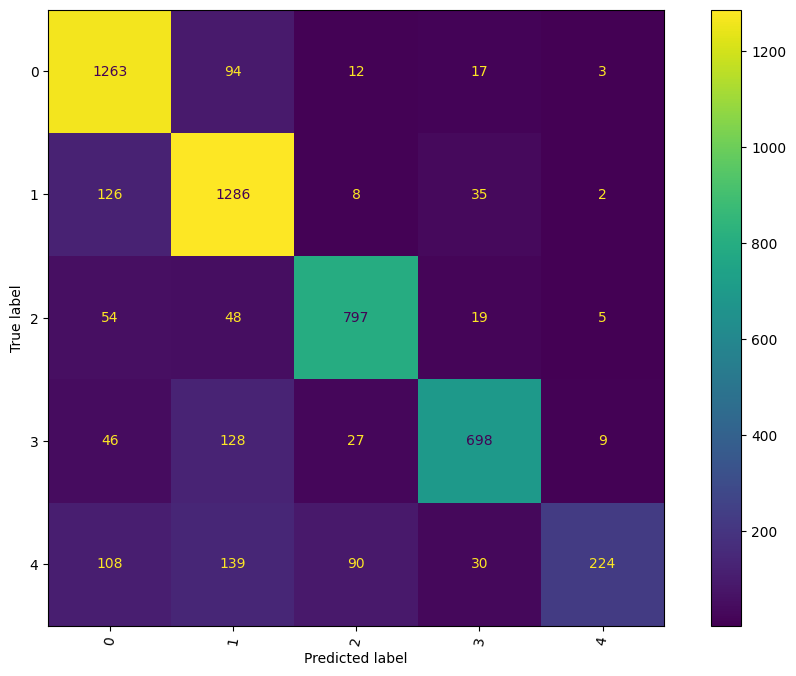

In [66]:
log_model5 = RandomForestClassifier(random_state=40)
# fit model
log_model5.fit(X_train,y_train)
# display classification report
report5=[]
display_classification(log_model5,report5)

With the Simple  Random Forest Classifier Model we get accuracy of around 81%

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score:  0.6932414634048671
Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 500}
Train ROC AUC Score: 0.98
Train Accuracy: 0.72
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      4063
           1       0.59      0.97      0.73      4411
           2       0.87      0.71      0.78      2901
           3       0.93      0.50      0.65      2638
           4       1.00      0.02      0.05      1791

    accuracy                           0.72     15804
   macro avg       0.84      0.62      0.61     15804
weighted avg       0.80      0.72      0.68     15804

Test ROC AUC Score: 0.96
Test Accuracy: 0.7
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1389
           1       0.55      0.94      0.70      1457
           2 

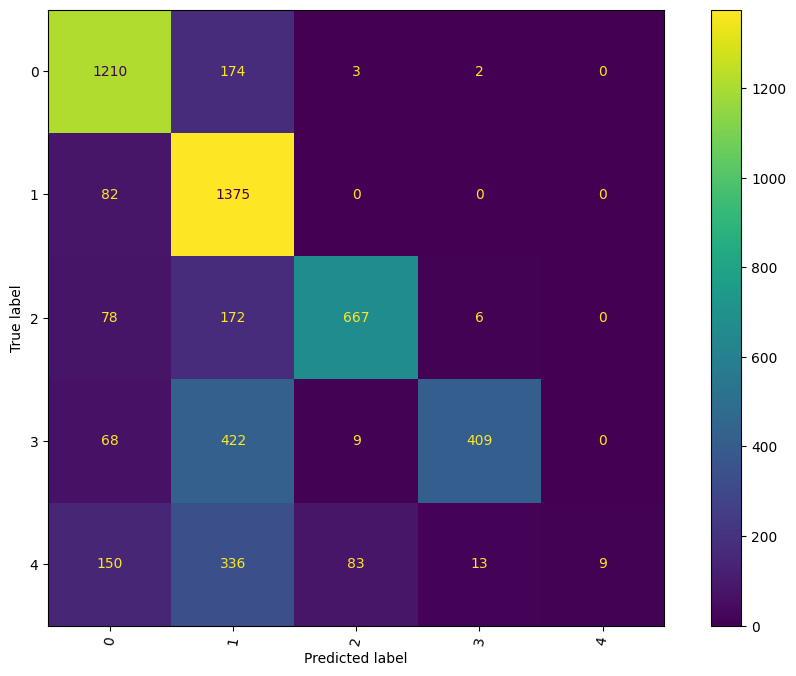

In [68]:
log_model6 = RandomForestClassifier(random_state=40, n_jobs = -1)

log_hyp6 = {'max_depth': [3, 4, 5, 10],
           'n_estimators':[100,200,500],
           'min_samples_leaf': [5,10,15]}


grid_search_model6 = grid_search(log_model6, folds, log_hyp6, scoring=None)

grid_search_model6.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_model6)

# Random Forest Classification Report
report6=[]
display_classification(grid_search_model6,report6)

#### MutiNominal Naive Bayes Classifier

Train ROC AUC Score: 0.96
Train Accuracy: 0.71
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      4063
           1       0.58      0.95      0.72      4411
           2       0.86      0.74      0.80      2901
           3       0.91      0.42      0.57      2638
           4       0.98      0.03      0.06      1791

    accuracy                           0.71     15804
   macro avg       0.82      0.61      0.60     15804
weighted avg       0.78      0.71      0.66     15804

Test ROC AUC Score: 0.94
Test Accuracy: 0.67
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1389
           1       0.53      0.91      0.67      1457
           2       0.86      0.73      0.79       923
           3       0.90      0.39      0.54       908
           4       1.00      0.02      0.03       591

    accuracy                

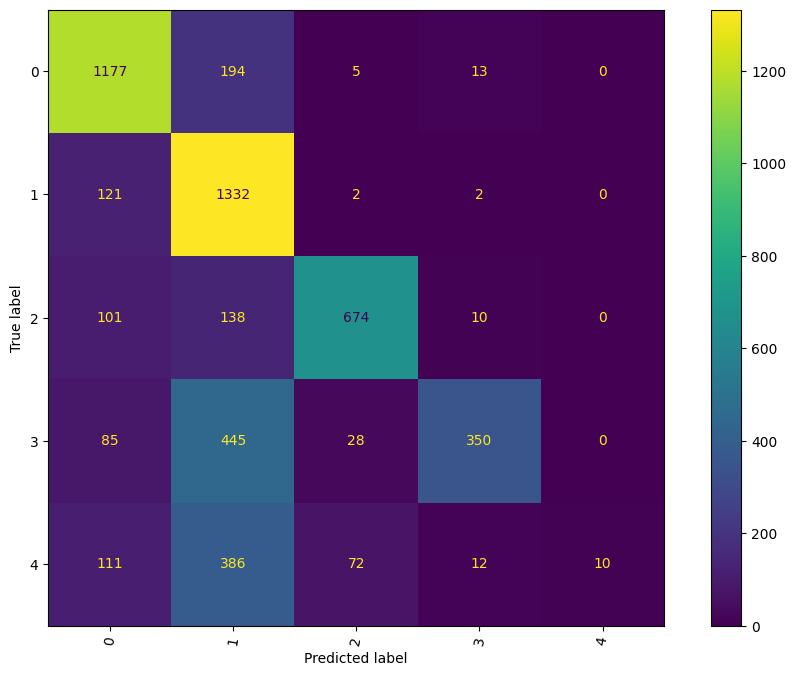

In [70]:
log_model7 = MultinomialNB()
# fit model
log_model7.fit(X_train,y_train)
# display classification report
report7=[]
display_classification(log_model7,report7)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7739813750655736
Best Hyperparameters:  {'alpha': 0.1}
Train ROC AUC Score: 0.98
Train Accuracy: 0.86
Classification Report for Train:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4063
           1       0.85      0.92      0.88      4411
           2       0.89      0.89      0.89      2901
           3       0.88      0.83      0.86      2638
           4       0.92      0.60      0.72      1791

    accuracy                           0.86     15804
   macro avg       0.88      0.83      0.85     15804
weighted avg       0.87      0.86      0.86     15804

Test ROC AUC Score: 0.95
Test Accuracy: 0.78
Classification Report for Test:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1389
           1       0.74      0.84      0.78      1457
           2       0.83      0.84      0.83       923
       

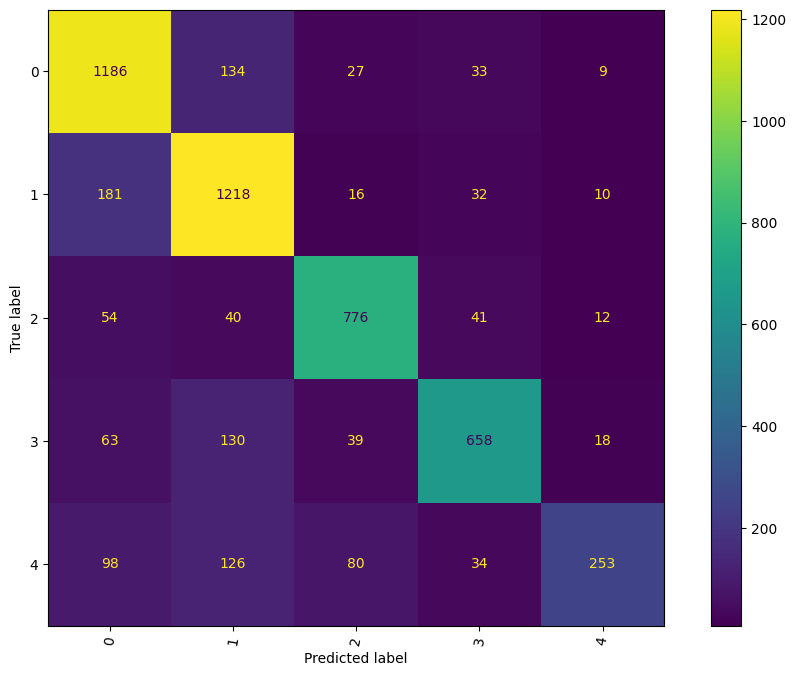

In [73]:
log_model8 = MultinomialNB()

log_hyp8 = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001) }


grid_search_model8 = grid_search(log_model8, folds, log_hyp8, scoring=None)

grid_search_model8.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_model8)

# Random Forest Classification Report
report8=[]
display_classification(grid_search_model8,report8)

In [102]:
custom_complaint = 'Hi, im having some issues with my credit card and Im hoping you can help me out. I recently noticed some unauthorized charges on my card and Im not sure what to do. Im also concerned about the interest rate on my card, which seems to be quite high. Could you please provide some guidance on how I can dispute these charges and possibly lower my interest rate? Thank you'

In [103]:
test_vector_count = vector_count.transform([custom_complaint])
test_tfidf = tfidf_transformer.transform(test_vector_count)

In [104]:
pred = grid_search_model2.predict(test_tfidf)
pred

array([1])

In [105]:
Topic_names = {
    0: 'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Others',
    3: 'Theft/Dispute Reporting', 4: 'Mortgage/Loan'
}

In [106]:
Topic_names[pred[0]]

'Credit card or prepaid card'